# Perceptron Lab Daniel Nybo






In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.datasets as data
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import random
import matplotlib.pyplot as plt
from tabulate import tabulate
import math
from astropy.table import QTable, Table, Column
from astropy import units as u

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- A way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and include your final weights in your report PDF.

In [ ]:

class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, deterministic=None):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.deterministic = deterministic

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        #adding bias nodes to each data row
        rows, columns = X.shape
        bias = np.ones((rows, 1), dtype=X.dtype)
        X = np.hstack((X,bias))
        row, column = X.shape
        
        if (np.count_nonzero(initial_weights) < 1):
          self.weights = np.zeros(column)
        elif initial_weights:
          self.weights = initial_weights
        else:
          self.weights = self.initialize_weights(column)
        
        if not self.deterministic==None:
          num_runs = self.deterministic
        else:
          num_runs = -1
        
        epoch_count = 0
        cur_acc = 0
        prev_acc = 0
        acc_diff = 1
        epochs = 0
        epochs = 0
        deltaWeights = np.zeros(column, dtype=float)
        times_the_same = 0
        mCR = []
        while (self.deterministic==None and times_the_same < 3) or epochs < num_runs:
          curr_acc = self.score(X[:,0:column-1],y)
          mCR.append(1-curr_acc)
          if (self.shuffle):
            X,y = self._shuffle_data(X,y)    
          for row_index in range(0, row):
            net = 0
            output = 0
            for column_index in range(0, column):
              net += self.weights[column_index] * X[row_index, column_index]
            output = 1 if net > 0 else 0
            for weight_index in range(0, column): 
              deltaWeights[weight_index] = (self.lr * (y[row_index, 0] - output) * X[row_index, weight_index])
              #print("Epoch ", i, "Row, ", weight_index, deltaWeights[weight_index], " = ", self.lr , " * (" , y[row_index, 0] , " - " , output[weight_index] , ") *" , X[row_index,weight_index])
              self.weights[weight_index] = self.weights[weight_index] + deltaWeights[weight_index]
          epochs += 1
          epoch_count += 1
          curr_acc = self.score(X[:,0:column-1], y)
          if not abs(curr_acc - prev_acc):
            times_the_same += 1
          acc_diff = abs(curr_acc - prev_acc)
          prev_acc = curr_acc
          #mCR.append(1-curr_acc)
      
        #print(net, output, self.weights)
        self.mCR = mCR
        self.epoch_count = epoch_count
        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        rows, columns = X.shape
        bias = np.ones((rows, 1), dtype=X.dtype)
        X = np.hstack((X,bias))
        row, column = X.shape
        output = np.zeros(row, dtype=float)
        #print(self.weights)
        for row_index in range(0, row):
          net = 0
          for column_index in range(0, column):
            net += self.weights[column_index] * X[row_index, column_index]
          output[row_index] = 1 if net > 0 else 0
       
        return output, output.shape

    def initialize_weights(self, numWeights):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        self.weights = np.random.uniform(-1, 1, numWeights)
        return self.weights

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        numCorrect = 0
        output,shape = self.predict(X)
        (row,) = shape
        for index in range(0,row):
          if output[index] == y[index]:
            numCorrect += 1
        return numCorrect/row

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        
        shuffle_data = np.hstack((X,y))
        #print(shuffle_data)
        row, column = shuffle_data.shape
        if self.shuffle:
          np.take(shuffle_data,np.random.permutation(shuffle_data.shape[0]),axis=0,out=shuffle_data)
          X = shuffle_data[:,0:column-1]
          y = shuffle_data[:,column-1:column]
          #print(shuffle_data)
        return X, y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## 1.1 Debug 

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Parameters:

Learning Rate = 0.1\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

Expected Results

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [ ]:
# Load debug data
#getting training data to put into array
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep.arff
data = arff.loadarff('linsep.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8').astype(int)
#print(df)

#convert data frame to numpy array
np_data = np.array(df)
#print(np_data)
row, column = np_data.shape
x = np_data[:,0:column-1]
y = np_data[:,column - 1:column]


# Train on debug data
#perform the train operation on data
myModel = PerceptronClassifier(.1,False,10)
myModel.fit(x,y,[0,0,0])

# Check accuracy and weights
output,out_shape = myModel.predict(x) 
print("Accuracy = ", round(myModel.score(x, y), 2))
print("Weights = ", myModel.get_weights())

## 1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [ ]:
# Load debug data
#getting training data to put into array
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output bank.arff
data = arff.loadarff('bank.arff')
evalDf = pd.DataFrame(data[0])
evalDf['class'] = evalDf['class'].str.decode('utf-8').astype(int)
#print(df)

#convert data frame to numpy array
np_evalData = np.array(evalDf)
#print(np_data)
row, column = np_evalData.shape
ev_X = np_evalData[:,0:column-1]
ev_Y = np_evalData[:,column - 1:column]

# Train on evaluation data
#perform the train operation on data
evModel = PerceptronClassifier(.1,False,10)
evModel.fit(ev_X,ev_Y,[0,0,0,0,0])

# Print  weights 
output,out_shape = evModel.predict(ev_X) 
print("Accuracy = ", evModel.score(ev_X, ev_Y))
print("Weights = ", evModel.get_weights())

The final weights for the Evaluation Data Set are as follows :
[-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]

With Accuracy of .99 

## 2. (10%) Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.
- Graph each dataset

![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

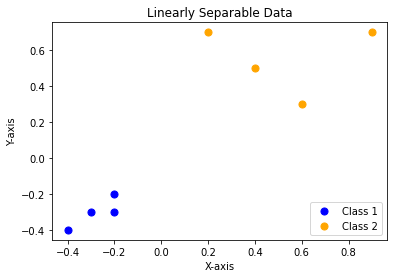

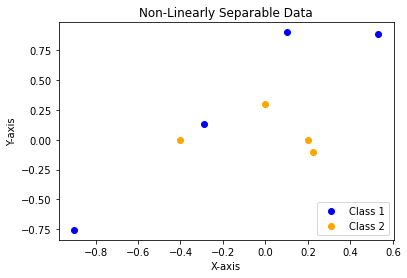

In [ ]:
# Create 2 datasets
dataSet_1_1 = np.array([[-.2, -.2, 1],[-.3, -.3, 1],[-.4, -.4, 1],[-.2, -.3, 1]])
dataSet_1_0 = np.array([[.2, .7, 0],[.4, .5, 0],[.6, .3, 0],[.9, .7, 0]])

dataSet_2_1 = np.array([[-.288899, .1322, 1],[.102934, .8999, 1],[-.90123, -.75584, 1],[.53213, .888854, 1]])
dataSet_2_0 = np.array([[.222, -.1, 0],[-.4, 0, 0],[0, .3, 0],[.2, 0, 0]])


dataSet_1 = np.vstack([dataSet_1_1,dataSet_1_0])
dataSet_2 = np.vstack([dataSet_2_1,dataSet_2_0])

Class1_ds1 = plt.scatter(dataSet_1_1[:,0], dataSet_1_1[:,1], c = "blue",  
            s = 50) 
Class2_ds1= plt.scatter(dataSet_1_0[:,0], dataSet_1_0[:,1], c = "orange",  
            s = 50)
plt.title("Linearly Separable Data") 
plt.xlabel("X-axis") 
plt.ylabel("Y-axis") 
plt.legend((Class1_ds1, Class2_ds1), ("Class 1", "Class 2"), loc='lower right')
plt.show()

Class1_ds2 = plt.scatter(dataSet_2_1[:,0], dataSet_2_1[:,1], c ="blue")
Class2_ds2 = plt.scatter(dataSet_2_0[:,0], dataSet_2_0[:,1], c ="orange")
plt.title("Non-Linearly Separable Data")
plt.xlabel("X-axis") 
plt.ylabel("Y-axis") 
plt.legend((Class1_ds2, Class2_ds2), ("Class 1", "Class 2"), loc='lower right')
plt.show()


## 3. (10%) Train on both sets with your perceptron code.

- Use a couple different learning rates.


In [ ]:
# Train on each dataset
r1,c1 = dataSet_1.shape

for i in (5, 50, 35):
  ds1Model = PerceptronClassifier(i/100,False,None)
  X = dataSet_1[:,0:c1-1]
  y = dataSet_1[:,c1-1:c1]
  ds1Model.fit(X, y,[0,0,0])
  print("Linearly Separable data: Data Set 1")
  print("learing rate = ", ds1Model.lr)
  print("weights = ", ds1Model.get_weights())
  print("accuracy = ", ds1Model.score(X,y))
  print("number of epochs = ", ds1Model.epoch_count, "\n")

  r2,c2 = dataSet_2.shape
  ds2Model = PerceptronClassifier(i/100,False,None)
  X2 = dataSet_2[:,0:c1-1]
  y2 = dataSet_2[:,c1-1:c1]
  ds2Model.fit(X2, y2,[0,0,0])
  print("Non-Linearly Separable data: Data Set 2")
  print("learing rate = ", ds2Model.lr)
  print("weights = ", ds2Model.get_weights())
  print("accuracy = ", ds2Model.score(X,y))
  print("number of epochs = ", ds2Model.epoch_count, "\n")

Linearly Separable data: Data Set 1
learing rate =  0.05
weights =  [-0.02  -0.045  0.   ]
accuracy =  1.0
number of epochs =  4 

Non-Linearly Separable data: Data Set 2
learing rate =  0.05
weights =  [-0.09049095  0.035681   -0.05      ]
accuracy =  0.5
number of epochs =  7 

Linearly Separable data: Data Set 1
learing rate =  0.5
weights =  [-0.2  -0.45  0.  ]
accuracy =  1.0
number of epochs =  4 

Non-Linearly Separable data: Data Set 2
learing rate =  0.5
weights =  [-0.9049095  0.35681   -0.5      ]
accuracy =  0.5
number of epochs =  7 

Linearly Separable data: Data Set 1
learing rate =  0.35
weights =  [-0.14  -0.315  0.   ]
accuracy =  1.0
number of epochs =  4 

Non-Linearly Separable data: Data Set 2
learing rate =  0.35
weights =  [-0.63343665  0.249767   -0.35      ]
accuracy =  0.5
number of epochs =  7 



Discuss the effect of learning rate, including how many epochs are completed before stopping. (For these cases, learning rate should have minimal effect, unlike with the Backpropagation lab.)



There is no correlation between the learning rate and the number of epochs in this data set. The learning rate does not effect the number of epochs because there are only little bits of data here.


## 4. (10%) Graph the instances and decision line for the two cases above (with LR=.1)
 
 - For all graphs always label the axes!

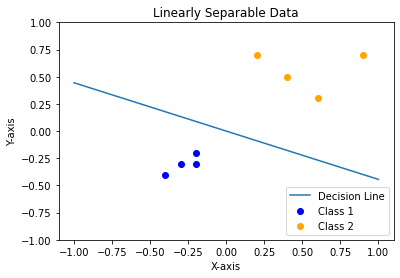

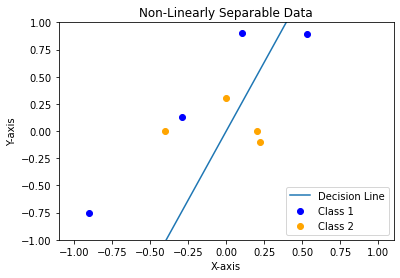

In [ ]:
# Graph decision line
Class1_ds1 = plt.scatter(dataSet_1_1[:,0], dataSet_1_1[:,1], c = "blue",  
            label = "Class 1") 
Class2_ds1= plt.scatter(dataSet_1_0[:,0], dataSet_1_0[:,1], c = "orange",  
            label = "Class 2")
plt.title("Linearly Separable Data") 
plt.xlabel("X-axis") 
plt.ylabel("Y-axis")
s = np.linspace(-1,1,100)
w1 = ds1Model.weights[0]
w2 = ds1Model.weights[1]
b = ds1Model.weights[2]
plt.ylim(-1, 1)
line1 = plt.plot(s,((-1*w1/w2)*s - (b/w2)), label="Decision Line")
plt.legend(scatterpoints=1, loc='lower right')
plt.show()

#data set 2 with non-linearly separable data
Class1_ds2 = plt.scatter(dataSet_2_1[:,0], dataSet_2_1[:,1], c ="blue",label = "Class 1")
Class2_ds2 = plt.scatter(dataSet_2_0[:,0], dataSet_2_0[:,1], c ="orange",label = "Class 2")
s = np.linspace(-1,1,100)
w1_2 = ds2Model.weights[0]
w2_2 = ds2Model.weights[1]
b_2 = ds2Model.weights[2]
plt.ylim(-1, 1)
line1 = plt.plot(s,((-1*w1_2/w2_2)*s - (b/w2_2)), label="Decision Line")
plt.title("Non-Linearly Separable Data")
plt.xlabel("X-axis") 
plt.ylabel("Y-axis") 
plt.legend(scatterpoints=1, loc='lower right')
plt.show()


## 5. (20%) Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 5.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the average of these values for the 5 trials in the table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| Average each value by trial| | | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [ ]:
# Create table any way you like
#getting training data to put into array
!curl https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff --output voting.arff
data = arff.loadarff('voting.arff')
df = pd.DataFrame(data[0])
for datum in df:
  df[datum] = df[datum].str.decode('utf-8').astype(str)
#print(df)
#convert data frame to numpy array
np_data = np.array(df)
row,col = np_data.shape
X = np.array(np_data[:,0:col-1])
y = np.array(np_data[:,col-1:col])
X[X=='y'] = 1.
X[X=='n'] = 0.
y[y=='democrat'] = 1.
y[y=='republican'] = 0.

votingModel = PerceptronClassifier(.1,True,None)
vData = np.hstack((X,y))

train_accuracy = []
test_accuracy = []
num_epochs = []
mCR = []
#now train data
for i in range(0, 5):
  np.random.shuffle(vData)
  shuffled_training_set = vData[0:math.ceil(row*.7),:]
  shuffled_test_set = vData[math.ceil(row*.7):-1,:]
  train_X = shuffled_training_set[:,0:col-1]
  train_y = shuffled_training_set[:,col-1:col]
  test_X = shuffled_test_set[:,0:col-1]
  test_y = shuffled_test_set[:,col-1:col]
  votingModel = PerceptronClassifier(.1,True,None)
  votingModel.fit(train_X, train_y)
  train_accuracy.append(votingModel.score(train_X, train_y))
  test_accuracy.append(votingModel.score(test_X, test_y))
  num_epochs.append(votingModel.epoch_count)
  mCR.append(votingModel.mCR)


train_avg = np.average(train_accuracy)
test_avg = np.average(test_accuracy)
epoch_avg = np.average(num_epochs)
strings = ["","","","",""]
table = Table([strings,range(1, 6), train_accuracy, test_accuracy, num_epochs], names=[" ", "TestNum", "TrainAcc", "TestAcc", "Epochs"])
table['TrainAcc'].info.format = '.3f'
table['TestAcc'].info.format = '.3f'
table.add_row(["Averages", 0, train_avg, test_avg, epoch_avg])
print(table)
#print(votingModel.weights)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43825  100 43825    0     0   602k      0 --:--:-- --:--:-- --:--:--  611k
         TestNum TrainAcc TestAcc Epochs
-------- ------- -------- ------- ------
               1    0.963   0.964     34
               2    0.960   0.956     29
               3    0.972   0.956     79
               4    0.969   0.927     65
               5    0.972   0.964     28
Averages       0    0.967   0.953     47


### 5.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 



Based on the Weights, the model has predicted that the 4th attribute and the 11th attribute are most key in determining voting choice. There is also a noticable influence by attribute 3, 9 and 10. This shows us that the way voters vote on these issues are more likely to influence them in voting either Democrat or Republican. Table and weights below

         TestNum TrainAcc TestAcc Epochs
          ------- -------- ------- ------
               1    0.969   0.964     41
               2    0.960   0.949     38
               3    0.972   0.934     30
               4    0.966   0.949     32
               5    0.963   0.964     60
    Averages   0    0.966   0.952     40

Weights:
the most obvious winners are attribute 4 and 11 after running it several trial runs. Nodes 3,8,9 and 10 are also influential 
[ 2.00000000e-01  4.00000000e-01  8.00000000e-01 -1.70000000e+00
 -7.00000000e-01  2.00000000e-01 -7.00000000e-01 -8.00000000e-01
  7.00000000e-01 -4.00000000e-01  9.00000000e-01  2.77555756e-17
 -2.00000000e-01 -1.00000000e-01  7.00000000e-01 -5.00000000e-01
  1.40000000e+00]

### 5.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

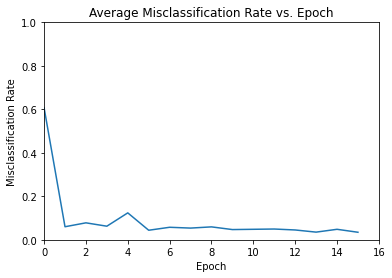

In [ ]:
# Graph here
minLen = 1000
for i in mCR:
  if len(i) < minLen:
    minLen = len(i)
avg_mCR = []
for i in range(0, minLen):
  avg = 0
  for j in range(0,5):
    avg += mCR[j][i]
  avg_mCR.append(avg/5)

def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.ylim(0,1)
    plt.xlim(0,minLen)
    plt.show()

plot_misclassification(avg_mCR)    


## 6. (10%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above and also one other data set of your choice.

- Report and compare your results.
- Try out some of the hyper-parameters that scikit-learn makes available on your own perceptron.

In [ ]:
# Load sklearn perceptron()
np_data = np.array(df)
row,col = np_data.shape


np_data[np_data=='y'] = 1
np_data[np_data=='n'] = 0
np_data[np_data=='democrat'] = 1
np_data[np_data=='republican'] = 0
np_data = np_data.astype(float)

# Train on voting datase
X = np.array(np_data[:,0:col-1])
y = np.array(np_data[:,col-1:col])
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
p = Perceptron(tol=1e-3, random_state=0)
p.fit(X_train, y_train)
print(round(p.score(X_test,y_test), 4))
print(p.n_iter_)

# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
p = Perceptron(tol=1e-3, random_state=0, early_stopping=True)
p.fit(X_train, y_train)
print(round(p.score(X_test,y_test), 4))
print(p.n_iter_)

# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
p = Perceptron(tol=1e-3, random_state=0, max_iter=3)
p.fit(X_train, y_train)
print(round(p.score(X_test,y_test), 4))
print(p.n_iter_)

# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
p = Perceptron(tol=1e-3, random_state=0, max_iter=1)
p.fit(X_train, y_train)
print(round(p.score(X_test,y_test), 4))
print(p.n_iter_)

# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
p = Perceptron(tol = .00000001)
p.fit(X_train, y_train)
print(round(p.score(X_test,y_test), 4))
print(p.n_iter_)


#second data set
#getting training data to put into array
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output aba.arff
#data = aba.loadarff('aba.arff')
#df = pd.DataFrame(data[0])

#second data set



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  C

0.9353
7
0.9712
6
0.9424
3
0.8633
1
0.9209
8
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   650k      0 --:--:-- --:--:-- --:--:--  647k


AttributeError: ignored

It looks like the hyperparameters do change it a bit but in the case of limiting the number of iterations it doesent look like it changes the accuracy very much until its limited to very few ~1 iteration. The model is very accurate at even 3 iterations. It is also notable that when tolerance is set very low it also reduces the accuracy. 

## 7. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.